In [1]:
#En este ejemplo vamos a coger los puntos del xml de paparazzi, vamos a optimizar el camino con un TSP y posteriormente vamos a 
#calcular las curvas de Bezier mas óptimas

In [2]:
#Cargamos los módulos que se van a necesitar
import pandas as pd

import numpy as np

import matplotlib
matplotlib.use('Qt5Agg')  # Cambia el backend a Qt5Agg para mostrar ventanas gráficas
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from pymoo.core.problem import ElementwiseProblem

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

from matplotlib import style

#Para que el primer punto sea el inicial
from pymoo.core.repair import Repair 

#Diferentes funciones de la biblioteca para optimizar (pymoo)
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.problems.single.traveling_salesman import create_random_tsp_problem
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.operators.mutation.bitflip import BitflipMutation

In [3]:
from lxml import etree

# Ruta a tu archivo XML y DTD
xml_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA_BZ_V4_optimizar.xml'
dtd_file = '/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/flight_plan.dtd'

# Cargar el DTD
with open(dtd_file, 'r') as dtd_f:
    dtd = etree.DTD(dtd_f)

# Cargar el archivo XML
with open(xml_file, 'r') as xml_f:
    xml_content = xml_f.read()

# Validar el XML contra el DTD
try:
    xml_doc = etree.fromstring(xml_content)
    if dtd.validate(xml_doc):
        print("El archivo XML es válido.")
    else:
        print("El archivo XML no es válido.")
        print("Errores:")
        for error in dtd.error_log:
            print(f"Línea {error.line}: {error.message}")
except etree.XMLSyntaxError as e:
    print("Error de sintaxis XML:")
    print(e)


El archivo XML es válido.


In [5]:
#En primer lugar cargamos todos los archivos necesarios. Estos son los siguientes:
#1- Datos.txt -> Nos dice si queremos mapa o no, número de segmentos y número de puntos de control
#2- Coordenadas.txt -> Nos dice las coordenadas de los puntos de control
#3- flight_plan -> Nos da todos los datos de lo que se desea en la ruta (Puntos de paso, regiones...)

#flightplan_entrada = input("Introduce el archivo que quiere optimizar con la extensión .xml: ")
#flightplan_salida = input("Introduce como quiere llamar archivo de salida con .xml: ")

#Leemos los archivos sacados del boton de planificación
Estrategia = pd.read_csv('/home/dacya-iagesbloom/Desktop/PprzGCS/datos.txt', delimiter=':', header = None) #Datos.txt
Coordenadas = pd.read_csv('/home/dacya-iagesbloom/Desktop/PprzGCS/coordenadas.txt', delimiter=',', header=None) #Coordenadas.txt

#Carga de archivo XML
import xml.etree.ElementTree as ET
from xml.dom import minidom

tree = ET.parse('/home/dacya-iagesbloom/Documents/paparazzi/conf/flight_plans/UCM/PRUEBA_BZ_V4_optimizar.xml')
root = tree.getroot()

# Encontrar todos los waypoints
way_points = root.find('waypoints')
waypoint_list = []
unchanged_points = []

#RECORDATORIO CHECKPOINT: EL CÓDIGO ESTABA HECHO PARA DECLARAR LAS VARIABLES CON X,Y NO CON LON LAT. EL PROBLEMA VIENE DE QUE CON
#EL FLIGHT_PLAN HECHO POR MI EL SIMULADOR NO SIGUE BIEN LA RUTA. POR TANTO, ESTOY PROBANDO CON UNO QUE (A VECES) SÍ QUE HACE BIEN 
#LA RUTA. PERO HAY QUE O PASAR LON Y LAT A X E Y O QUE SEA CAPAZ DE LEER LON, LAT

# Almacenar los waypoints existentes en una lista
for waypoint in way_points.findall('waypoint'):
    name = waypoint.get('name')
    #print(name)
    if name.startswith('BZ'):
        #lat = float(waypoint.get('lat'))
        #lon = float(waypoint.get('lon'))
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        print(waypoint.get('x'))
        print(y)
        #print(type(lat))
        waypoint_list.append((name, x, y))
        #waypoint_list.append((name, lat, lon))
    else:
        x = float(waypoint.get('x'))
        y = float(waypoint.get('y'))
        unchanged_points.append((name, x, y))
        #waypoint_list.append((name, lon, lat))
#Limpiamos way_points
way_points.clear()

#Convertimos tanto la lista de waypoints como unchanged en una lista y las unimos
waypoints = np.array([[nombre, lat, lon] for nombre, lat, lon in waypoint_list])
unchangedpoints = np.array([[nombre, x, y] for nombre, x, y in unchanged_points])
points = np.concatenate((waypoints, unchangedpoints), axis=0)


#Definimos una matriz unicamente con las coordenadas de cada parada:
paradas = (waypoints[:,-2:])
print(paradas)
#Definimos parámetros del barco
velocidad_media = 40

33.3
12.3
20.6
-0.2
6.5
46.4
35.4
33.9
[['33.3' '12.3']
 ['20.6' '-0.2']
 ['6.5' '46.4']
 ['35.4' '33.9']]


In [6]:
#Ahora una vez tenemos los puntos vamos a añadir el algoritmo de optimización

#COSA TO DO DESPUÉS DE HABER LOGRADO UNIR EL OPTIMIZADOR CON LA RECOGIDA DE DATOS: FIJAR EL PUNTO INICIAL Y FINAL
stops=paradas

#Definimos el problema
class RUTA (ElementwiseProblem):

    def __init__(self, **kwargs):
        
        start_idx = 0  # Primer punto
        end_idx = len(waypoints)-1 # Último punto
        
        n_stops, _ = stops.shape #Aquí coge las filas (Por tanto el número de paradas)
        #n_stops=n_stops-1
        self.stops = stops
        self.D = cdist(stops, stops)
        self.start_idx = start_idx
        self.end_idx = end_idx
        super(RUTA, self).__init__(
            n_var=n_stops,
            n_obj=1,
            n_constr=2,
            xl=0,
            xu=len(stops),
            vtype=int,
            **kwargs
        )

    #Definimos las funciones de evaluación y las reestricciones
    def _evaluate(self, x, out, *args, **kwargs):
        distancia=self.get_route_length(x)
        tiempo=self.get_route_length(x)/velocidad_media
        out['F'] = [distancia]

        #Voy a poner aquí las restricciones
        #Restricciones
        
        #Max_dist=self.get_route_length(x)-250
        
        #Max_tiempo=self.get_route_length(x)/velocidad_media-250

        #x_ord=np.sort(x)
        #penalty_paradas=0
        #for i in range(len(x_ord)-1):
        #   if x_ord[i] == x_ord[i+1]:
        #       penalty_paradas=10000
        g1 = 1 if x[0] != self.start_idx else 0  # Penaliza si el primer punto no es start_idx
        g2 = 1 if x[-1] != self.end_idx else 0   # Penaliza si el último punto no es end_idx
        #out["G"]=[Max_dist, Max_tiempo + penalty_paradas]
        
        out["G"] = [g1, g2]

    #Distancia de la ruta
    def get_route_length(self, x):
        n_stops = len(x)
        dist = 0
        for k in range(n_stops - 1):
            i, j = x[k], x[k + 1]
            dist += self.D[i, j]
        return dist

#Visualización de los resultados
def visualize_3(problem, x, n, fig=None, ax=None, show=True, label=True):
    with plt.style.context('ggplot'):
        # Asegúrate de que x sea un array unidimensional
        x = np.asarray(x)  # Convierte x a un array de numpy

        if x.ndim == 1:  # Asegúrate de que es un vector
            x = x.flatten()  # Aplana el array para asegurarte de que sea 1D

        if fig is None or ax is None:
            fig, ax = plt.subplots()

        # Plot de las ciudades usando scatter plot
        ax.scatter(problem.stops[:, 0], problem.stops[:, 1], s=150)
        if label:
            # Anota las ciudades
            for i, c in enumerate(problem.stops):
                ax.annotate(str(i), xy=c, fontsize=10, ha="center", va="center", color="white")

        # Plotea la línea en el camino
        for i in range(len(x) - 1):
            current = int(x[i])  # Asegúrate de convertir a entero
            next_ = int(x[i + 1])  # Asegúrate de convertir a entero
            ax.plot(problem.stops[[current, next_], 0], problem.stops[[current, next_], 1], 'r--')

        fig.suptitle(f"Route length: {problem.get_route_length(x)} km \nRoute time: {problem.get_route_length(x) * 60 / velocidad_media} min")

        if show:
            plt.show()

In [7]:
#Para en caso en el que tengamos más de un barco hará un clustering con kmeans para clasificar las diferentes paradas
#De momento dejaremos el n_barcos fijos igual a 1 pero el algoritmo está preparado para que en algún momento se puedan añadir más
n_barcos = 1

style.use('ggplot') or plt.style.use('ggplot')

x_k, y=paradas[0], paradas[1]
X_scaled = scale(paradas)
modelo_kmeans = KMeans(n_clusters=n_barcos, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

# Clasificación con el modelo kmeans

y_predict = modelo_kmeans.predict(X=X_scaled)

#Representación
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for i in np.unique(y_predict):
    ax.scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 40,
    marker = 'o',
    label  = 'centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

0

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

Maximum Span: 97.994
Function Evaluations: 416
[0 1 2 3]


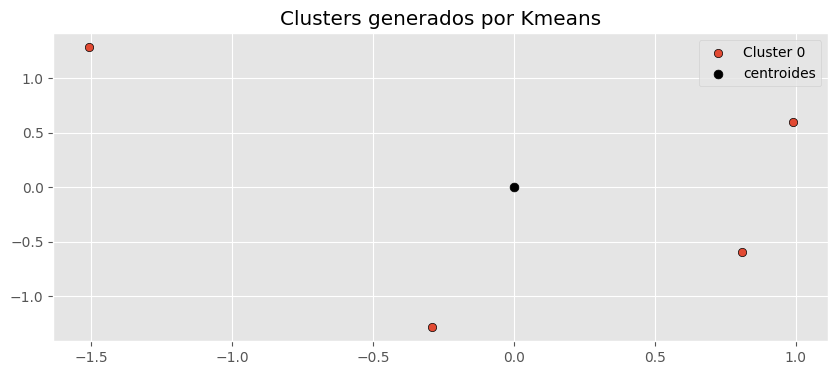

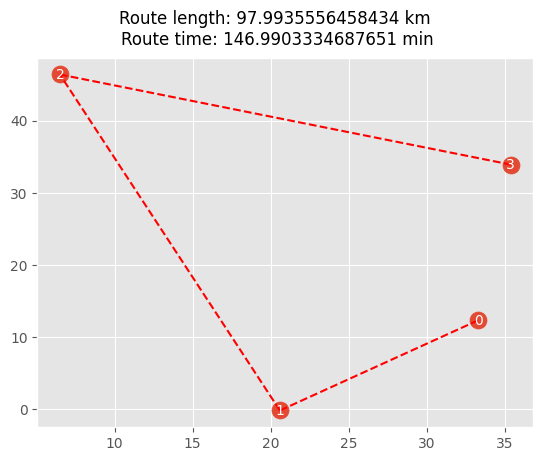

In [8]:
#Creamos un diccionario para almacenar cada ruta
rutas={}
stops=paradas.astype(float)
fitness=[]

for i in range(n_barcos):
    print(i)
    grupos_finales=np.array([stops[:,0].T, stops[:,1].T, y_predict])
    grupos_finales=grupos_finales.T
    rutas[f"ruta_{i}"]=grupos_finales[grupos_finales[:,2]==i][:,:2]
from pymoo.core.sampling import Sampling
for i in range(n_barcos):
    n_stops=len(stops)
    problem = RUTA()

        
    class CustomSampling(Sampling):
        def _do(self, problem, n_samples, **kwargs):
            # Generar n_samples rutas aleatorias
            samples = []
            for _ in range(n_samples):
                # Crear una ruta aleatoria (permutación de las paradas)
                route = np.random.permutation(n_stops)
                #print(f"n_paradas {n_stops}")
                samples.append(route)
                #print(f"samples {samples}")
            return np.array(samples)
            
    #Muestra
    sampling=CustomSampling()  
    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling,
        mutation=InversionMutation(),
        #mutation=BitflipMutation(),
        crossover=OrderCrossover(),
        eliminate_duplicates=True,
        save_history=True,
        #verbose=True
    )

    #Optimización    
    res = minimize(
        problem,
        algorithm,
        termination=('n_gen',100),
        seed=1,
        verbose=False,
    )
    print("Maximum Span:", np.round(res.F[0], 3))
    print("Function Evaluations:", res.algorithm.evaluator.n_eval)
    print(res.X)
    %matplotlib inline
    visualize_3(problem, res.X, n_barcos)
    


In [9]:
dtype = [('nombre', 'U10'), ('x', 'f4'), ('y', 'f4')]  # U10 para string, f4 para float
resultado = np.zeros(len(res.X),dtype=dtype)

for i in range(len(res.X)):
    idx = res.X[i]
    
    resultado[i] = (f'BZ{i}', waypoint_list[idx][1], waypoint_list[idx][2])

In [10]:
Puntos_paso = np.vstack((resultado['x'], resultado['y'])).T

In [11]:
#Ahora viene la implementación de las curvas de Bezier

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.optimize import minimize

def get_bezier_parameters(X, Y, degree=3):
    """Optimización de parámetros de una curva de Bézier de grado N."""
    
    if degree < 1:
        raise ValueError('degree must be 1 or greater.')

    if len(X) != len(Y):
        raise ValueError('X and Y deben tener la misma longitud.')

    if len(X) < degree + 1:
        raise ValueError(f'Deben haber al menos {degree + 1} puntos para '
                         f'determinar los parámetros de una curva de grado {degree}. '
                         f'Got only {len(X)} points.')

    def bpoly(n, t, k):
        """Polinomio de Bernstein cuando a = 0 y b = 1."""
        return t ** k * (1 - t) ** (n - k) * comb(n, k)

    def bmatrix(T):
        """Matriz de Bernstein para curvas de Bézier."""
        return np.matrix([[bpoly(degree, t, k) for k in range(degree + 1)] for t in T])

    # Nueva función de costo que incluye penalización por la longitud y suavidad
    def cost_function(control_points, X, Y):
        control_points = np.reshape(control_points, (-1, 2))  # Reestructurar los puntos de control
        T = np.linspace(0, 1, len(X))  # Parámetros t
        M = bmatrix(T)  # Matriz de Bernstein
        bezier_points = np.dot(M, control_points)  # Puntos de la curva de Bézier generados
        
        # Error cuadrático: comparar la curva con los puntos originales
        error = np.linalg.norm(bezier_points - np.array(list(zip(X, Y))), axis=1)
        
        # Penalización por la longitud total de la curva (ajustable según el peso)
        diff = np.diff(bezier_points, axis=0)
        total_length = np.sum(np.sqrt(np.sum(diff**2, axis=1)))
        
        # Combinación de error cuadrático y penalización
        cost = np.sum(error) + 0.1 * total_length  # El peso 0.1 es ajustable

        
        return cost

    # Puntos de control iniciales (se pueden generar aleatoriamente o derivar de puntos iniciales)
    initial_control_points = np.random.rand(degree + 1, 2) * 10

    # Minimizar la función de costo para obtener los puntos de control óptimos
    result = minimize(cost_function, initial_control_points.flatten(), args=(X, Y))

    # Extraer los puntos de control optimizados
    optimized_control_points = np.reshape(result.x, (-1, 2))

    return optimized_control_points.tolist()

# Ejemplo de uso:
X = [0, 1, 2, 3, 4]
Y = [0, 2, 3, 5, 4]
degree = 3

# Obtener los puntos de control óptimos
control_points = get_bezier_parameters(X, Y, degree)

# Graficar la curva optimizada
T = np.linspace(0, 1, 100)
def bpoly(n, t, k):
    return t ** k * (1 - t) ** (n - k) * comb(n, k)

def bezier_curve(t, control_points):
    degree = len(control_points) - 1
    return sum(comb(degree, k) * (t**k) * ((1-t)**(degree-k)) * np.array(control_points[k]) for k in range(degree+1))

curve = np.array([bezier_curve(t, control_points) for t in T])

plt.plot(X, Y, 'bo-', label='Datos originales')
plt.plot(curve[:, 0], curve[:, 1], 'r-', label='Curva Bézier optimizada')
plt.legend()
plt.show()


LinAlgError: Last 2 dimensions of the array must be square

In [ ]:
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=50):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

In [ ]:
#Añadimos los puntos
points = []
xpoints = Puntos_paso[:,0]
ypoints = Puntos_paso[:,1]
for i in range(len(xpoints)):
    points.append([xpoints[i],ypoints[i]])

In [ ]:
import matplotlib.pyplot as plt
# Plot the original points
plt.plot(xpoints, ypoints, "ro", markersize = 9, label='Original Points')
# Get the Bezier parameters based on a degree.
data = get_bezier_parameters(xpoints, ypoints, degree=5)
x_val = [x[0] for x in data]
y_val = [x[1] for x in data]
print(data)
# Plot the control points
plt.plot(x_val,y_val,'k--o', label='Control Points')
# Plot the resulting Bezier curve
xvals, yvals = bezier_curve(data, nTimes=1000)
plt.plot(xvals, yvals, 'b-', label='B Curve')
plt.legend()
plt.show()

In [ ]:
xpoints

In [ ]:
bezier_points.shape